In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import cv2
import os
import numpy as np
from PIL import Image
from nets.facenet.inceptionResNet import InceptionResNetV1
from nets.mtcnn.detector_face import MtcnnModel
from utils.visualization_utils import show_bboxes
from utils.box_utils import rect2square, convert_landmark_coordinate, compare_faces, face_distance
from utils.img_utils import Alignment_1

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
detector_model = MtcnnModel()
facenet_model = InceptionResNetV1()

Model Load Start>>>>>> 1606920147.7891707
model_data/facenet/facenet_keras.h5
Model Load Finished>>>>>> 15.427885293960571


In [28]:
class FaceRecognize_MTCNN(object):
    def __init__(self):
#         # 人脸检测网络
#         self.detector_model = MtcnnModel()
#         # 载入facenet网络
#         self.facenet_model = InceptionResNetV1()
        self.read_dataset()

    def read_dataset(self):    
        """
        对数据库中的人脸进行编码
        :known_face_encodings中存储的是编码后的人脸
        :nown_face_names为人脸的名字
        """
        self.known_face_encodings = []
        self.known_face_names = []

        face_list = os.listdir('face_dataset/dataset')
        for face in face_list:
            name = face.split('.')[0]

            # read image
            img = cv2.imread('./face_dataset/dataset/' + face)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             img = Image.open('./face_dataset/dataset/' + face)

            # detect face
            bounding_boxes, landmarks = detector_model.detectFace(Image.fromarray(img))
            # print("bounding_boxes.shape>>>>", bounding_boxes.shape) # (1, 5)
#             print("bouding_boxes>>>", bounding_boxes, '\n')
            # print("landmarks.shape>>>>", landmarks.shape) # (1, 10)
#             print("landmarks>>>", landmarks, '\n')

            # convert to square
            bounding_boxes = rect2square(bounding_boxes)
#             print("square.bouding_boxes>>>", bounding_boxes)

            # new relative landmarks posistion
            landmarks = convert_landmark_coordinate(landmarks)
            # print("new_landmarks>>>", landmarks, '\n') # (1, 10)

            # convert landmark to face image
            bounding_boxes = bounding_boxes[0]
#             print("conver_bbox>>>", bounding_boxes, '\n')
            landmarks = landmarks[0]
#             print("convert_landmarks_init>>>", np.reshape(landmarks, (5,2)), '\n')
            landmarks = (np.reshape(landmarks, (5,2)) - np.array([int(bounding_boxes[0]), int(bounding_boxes[1])])) / (bounding_boxes[3] - bounding_boxes[1]) * 160
#             print("convert_landmarks>>>", landmarks)  # (1, 10)
            
            # cut image
#             print("img.shape>>>", img.shape)
            cv2.imwrite('./face_dataset/faceset/'+ face , img)
            crop_img = img[int(bounding_boxes[1]):int(bounding_boxes[3]), int(bounding_boxes[0]):int(bounding_boxes[2])]
            crop_img = cv2.resize(crop_img, (160, 160))
            cv2.imwrite('./face_dataset/test/' + face, crop_img)
#             print("copy_img.shape>>>", crop_img.shape)
            
            # alignment
            new_img, _  = Alignment_1(crop_img, landmarks)
            cv2.imwrite('./face_dataset/align/' +  face, new_img)
#             print("new_img.shape>>>", new_img.shape, '\n')
            
            # encode with facetnet to get 128D
            new_img = np.expand_dims(new_img, 0)
#             print("new_img.shape>>>", new_img.shape)
            face_encoding = facenet_model.encode(new_img)
#             print("face_encoding>>>", face_encoding.shape)
            
            self.known_face_encodings.append(face_encoding)
            self.known_face_names.append(name)
            
    # 人脸识别(先定位，再进行数据库匹配）        
    def recognize(self, draw):
        height, width, _ = np.shape(draw)
        draw_rgb = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
#         print("draw_rgb.shape>>>", draw_rgb.shape)
        
        # detect face
        bounding_boxes, landmarks = detector_model.detectFace(Image.fromarray(draw_rgb))
#         print("detect.bounding_boxes.shape>>>", bounding_boxes)
#         print("detect.landmarks.shape>>>", landmarks, '\n')

        if len(bounding_boxes) == 0:
            return
        
        # convert to square(此mtcnn模型已校准)
        bounding_boxes = rect2square(bounding_boxes)
        bounding_boxes[:, 0] = np.clip(bounding_boxes[:, 0], 0, width)
        bounding_boxes[:, 1] = np.clip(bounding_boxes[:, 1], 0, height)        
        bounding_boxes[:, 2] = np.clip(bounding_boxes[:, 2], 0, width)        
        bounding_boxes[:, 3] = np.clip(bounding_boxes[:, 3], 0, height)
#         print("square.bounding_boxes.shape>>>", bounding_boxes, '\n')
        
        # convert landmark
        landmarks = convert_landmark_coordinate(landmarks)
        
        # encoding
        face_encodings = []
        for bbox, landmark in zip(bounding_boxes, landmarks):
#             print("zip.test.bbox>>>", bbox)
#             print("zip.test.landmark>>>", landmark)
            # convert landmark to face image
            landmark = (np.reshape(landmark, (5,2)) - np.array([int(bbox[0]), int(bbox[1])])) / (bbox[3] - bbox[1]) * 160
#             print("convert.landmark>>>", landmark)
            # cut image
            crop_img = draw_rgb[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
            crop_img = cv2.resize(crop_img, (160, 160))
#             print("crop_img.shape>>>", crop_img.shape)
            
            # align
            new_img, _ = Alignment_1(crop_img, landmark)
            cv2.imwrite('./face_dataset/align/' +  "test.jpg", new_img)
            
            # encode with facenet
            new_img = np.expand_dims(new_img, 0)
            face_encoding = facenet_model.encode(new_img)
            face_encodings.append(face_encoding)
#         print("face_encodings>>", face_encodings, '\n')
#         print("known_face_encodings>>", self.known_face_encodings, '\n')

        
        # compare encoding
        face_names = []
        for face_encoding in face_encodings:
            # compare face code with dataset
            matches = compare_faces(self.known_face_encodings, face_encoding, tolerance=0.9)
#             print("matches>>", matches)
            name = 'Unknown'
            # find min distance face
            face_distances = face_distance(self.known_face_encodings, face_encoding)
#             print("face_distances>>", face_distances)
            best_index = np.argmin(face_distances)
#             print("best_index>>", best_index)
            if matches[best_index]:
                name = self.known_face_names[best_index]
            face_names.append(name)
#         print("face_names>>>", face_names)
        
        # draw
        for bbox, name in zip(bounding_boxes, face_names):
            cv2.rectangle(draw, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0,0,255), 2)
            
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(draw, name, (int(bbox[0]), int(bbox[3])-15), font, 0.75, (255,255,255), 2)
            
        return draw

In [29]:
faceDetetor = FaceRecognize_MTCNN()

scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04']
number of different scales: 9
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03', '0.02', '0.01']
number of different scales: 12
RotationMatrix.shape>>> (2, 3)


In [30]:
# 人脸识别
video_capture = cv2.VideoCapture(0)
while True:
    ret, frame = video_capture.read()
    faceDetetor.recognize(frame)
    cv2.imshow("video", frame)
    if cv2.waitKey(20) & 0xFF == ord('q'): #(0x71 == 0x71)
        break
video_capture.release()
cv2.destroyAllWindows()

scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
numbe

scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
RotationMatrix.shape>>> (2, 3)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04', '0.03']
number of different scales: 10
RotationMatrix.shape>>> (2, 3)
R

In [10]:
img = Image.open('./face_dataset/dataset/hjk.jpg')
type(img)
a = np.asarray(img, 'float32')
a.shape

(517, 382, 3)

In [23]:
np.empty((0)).shape

(0,)

In [27]:
a = np.array([1,1,2])
b = np.array([2,2,3])
print(a - b)
np.linalg.norm(a - b, axis=1)

[-1 -1 -1]


AxisError: axis 1 is out of bounds for array of dimension 1

In [7]:
from detector import detect_faces
from utils.visualization_utils import show_bboxes
from PIL import Image
import torch

1.4.0
Predict start>>>>>
(615, 407)
scales: ['0.60', '0.42', '0.30', '0.21', '0.15', '0.11', '0.07', '0.05', '0.04']
number of different scales: 9
bounding_box.shape: (13, 5) (13, 10)


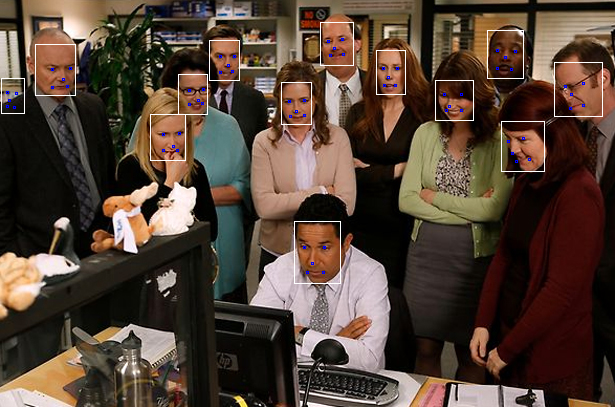

In [8]:
print(torch.__version__) #1.4.0
# print(torch.FloatTensor([[1,2,3]], requires_grad=True))
# x = torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)
# print(x)
print("Predict start>>>>>")
img = Image.open('face_dataset/office4.jpg')
print(img.size)
bounding_boxes, landmarks = detect_faces(img)
print("bounding_box.shape:", bounding_boxes.shape, landmarks.shape)
show_bboxes(img, bounding_boxes, landmarks)

In [21]:
x = torch.tensor([[1, -1], [1, 1]], dtype=torch.float32, requires_grad=True)
print(x)


a = torch.FloatTensor([1, 2, 3], requires_grad=True)

print(a)


tensor([[ 1., -1.],
        [ 1.,  1.]], requires_grad=True)


TypeError: new() received an invalid combination of arguments - got (list, requires_grad=bool), but expected one of:
 * (torch.device device)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, torch.device device)
      didn't match because some of the keywords were incorrect: requires_grad
 * (object data, torch.device device)
      didn't match because some of the keywords were incorrect: requires_grad
